In [1]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.mlab as mlab
import math

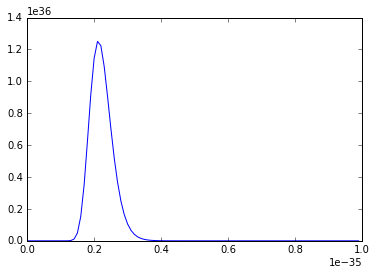

In [10]:
# for the bayesian stuff, but how exactly?
igdistr = stats.invgamma(a=46, scale =1e-34)
x = [val*0.0000000000000000000000000000000000001 for val in range(100)]
plt.plot(x, igdistr.pdf(x))
# also, can this be right? seems to be skewed towards extremely small variances....
#IF THIS IS TRUE I SHOULD PROBABLY MAKE SURE TO ALLOW FOR VERY SMALL VARIANCES BELOW

# Main goal: 
Fit a model for multisensory localization as a weighted average of visual and auditory information in a first round of experiments, then test it in a second round of experiment. The underlying assumption is that the mulitmodal localization can be modelled as some weighted average of the purely auditory/visual inputs via:

$$ L^* = w_v L^*_v +  w_a L^*_a  $$

where 
$w_v, w_a$  are the weights for the auditory/visual input, 
$L^*_w, L^*_a$ are the location estimates based on the purely visual/auditory input and 
$L^*$ is the location estimate based on the combined input.

## First round of experiments: purely visual & purely auditory
__Goals__:
- estimate weights $w_a, w_v$ for the auditory and visual information in the model of the multisensory setup
- find location estimates $L_a^*, L_v^*$ based on the purely auditory/visual inputs 

__Method__:
This will be achieved via  fitting a cumulative normal distribution to fit the datapoints we see - using the method of *Maximum Likelihood Estimation* (MLE). Recall that a normal distribution is defined by it's variance $\sigma^2$ and it's mean $\mu$. We thus want to estimate 

$$ \widehat{\sigma}^2, \widehat{\mu} = argmax_{\mu, \sigma} \prod_{t=1}^{T} p_t^{r_t} (1-p_t)^{1-r_t}
= argmax_{\mu, \sigma} \prod_{t=1}^{T} (\frac{1}{2}(1+erf(\frac{x-\mu}{\sqrt(2\sigma^2)})) )^{r_t} (1-(1+erf(\frac{x-\mu}{\sqrt(2\sigma^2)})))^{1-r_t}
$$

*TODO: annoying work of explaining all the variables and why a Bernoulli probability is the right choice*

Battaglia et al. suggested the following modification to the "classical MLE" model: transform it into a Bayesian model by adding priors $p(\sigma)$ and $p(\mu)$. The reason is the (evolutionary?) bias towards visual input as a more reliable source that the MLE model doesn't capture. In fact, some authors claim that this visual dominance is even so strong that the visual sensory input will completely dominate the auditory one (*visual capture theroy*). We thus refine our model into 

## this is not correct

$$ \widehat{\sigma}^2, \widehat{\mu} = argmax_{\mu, \sigma} \prod_{t=1}^{T} (\frac{1}{2}(1-erf(\frac{x-\mu}{\sqrt(2\sigma^2)})) )^{r_t} (1-(1-erf(\frac{x-\mu}{\sqrt(2\sigma^2)})))^{1-r_t} \cdot p_{\sigma^2}(\sigma^2) \cdot p_{\mu}(\mu)$$

The prior for $\mu$ is just a uniform distribution. More interestingly, the prior for $\sigma^2$ is an *inverse gamma distribution* that we model in a way that it favors small variances (corresponding to __reliable__ sensory input) 
[*TODO: explain why and how this is, write out mathzzz*].

needed python functionalities:
    - argmax / maximum likelihood
    - inverse gamma distribution
    - uniform distribution
    
possibly useful:
    - stats.bernoulli

In [3]:
from scipy import stats, optimize
from math import erf, sqrt, exp

In [4]:
def phi(x, mu, sigma2):
    # rewrote it to take sigma2 and then take the square root - not sure this is numerically smart... try without
    sigma = math.sqrt(sigma2)
    distribution = stats.norm(loc = mu, scale = sigma)
    return distribution.cdf(x)

In [5]:
phi(-6,0,5)

0.0036451790457678189

In [6]:
def round1_likelihood(degrees, answers, mu, sigma2):
# likelihood(R|mu, sigma) = 
    likelihood = 1
    # model the product
    for t in range(len(degrees)):
        # do we want the loc=0 here?
        likelihood = likelihood * stats.bernoulli.pmf(answers[t], phi(degrees[t], mu, sigma2))
    #print('The likelihood of these values is', likelihood)
    return likelihood

In [81]:
# methods that support passing bounds = 'TNC','L-BFGS-B', 'SLSQP'
def compute_MLE_1(data, global_opt = False):
    degrees = data[0, :]
    answers = data[1, :]
    if global_opt:
        min_kwargs = {'tol': 1e-100, 'method': 'TNC'}
        result = optimize.basinhopping(lambda x: 1-round1_likelihood(degrees, answers, *x), 
                                       x0 = [1.125,2], minimizer_kwargs=min_kwargs)
    else:
        result = optimize.minimize(lambda x: 1-round1_likelihood(degrees, answers, *x), x0 = [1.125,2] , 
                               tol = 1e-100, method =  'TNC' , bounds = [(-6.26, 6.25),(1e-36, None)], 
                               options={'disp':True})
    print(result)
    mu = result['x'][0]
    sigma2 = result['x'][1]
    return {'mu':mu, 'sigma2':sigma2}

In [12]:
# get the weights from the sigmas we calculated
def get_weight_from_variance(variance, other_variance):
    return (1/variance)/((1/variance + 1/other_variance))

wfv_vectorized = np.vectorize(get_weight_from_variance)

### Apply to our data - audio

In [43]:
all_participants_audio = []
for filename in os.listdir('data/preprocessed/audio'):
    if filename.endswith('.p'):
        print(filename)
        data = pickle.load( open('data/preprocessed/audio/' + filename, "rb" ) )
        number = filename[11:-2]
        #only consider the ones after the 4th where we didn't mess up (: 
        if int(number) > 4:
            results = compute_MLE_1(data)
            results['data'] = data
            results['participant'] = filename[:-2]
            print(results['participant'])
            all_participants_audio.append(results)

participant1.p
participant10.p
     fun: 0.99999999999994282
     jac: array([ 0.,  0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 1
     nit: 0
  status: 0
 success: True
       x: array([ 0.,  2.])
participant10
participant11.p
     fun: 1.0
     jac: array([ 0.,  0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 1
     nit: 0
  status: 0
 success: True
       x: array([ 0.,  2.])
participant11
participant12.p
     fun: 0.99999999977988141
     jac: array([ 0.,  0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 1
     nit: 0
  status: 0
 success: True
       x: array([ 0.,  2.])
participant12
participant13.p
     fun: 0.99777643390001458
     jac: array([  8.88178420e-08,   9.99200722e-08])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 33
     nit: 4
  status: 1
 success: True
       x: array([ 2.1314539 ,  0.05110352])
participant13
participant14.p
     fun: 0.0
     jac: array([ 0.,  0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    n

In [45]:
audio_results = pd.DataFrame(all_participants_audio)[['participant', 'mu', 'sigma2']]
audio_results

,participant,mu,sigma2
0,participant10,0.000000,2.000000e+00
1,participant11,0.000000,2.000000e+00
2,participant12,0.000000,2.000000e+00
3,participant13,2.131454,5.110352e-02
4,participant14,1.406976,1.000000e-36
5,participant15,0.000000,2.000000e+00
6,participant16,0.073994,1.811593e+00
7,participant17,0.000000,2.000000e+00
8,participant20,0.210142,1.605838e-01
9,participant5,0.000000,2.000000e+00


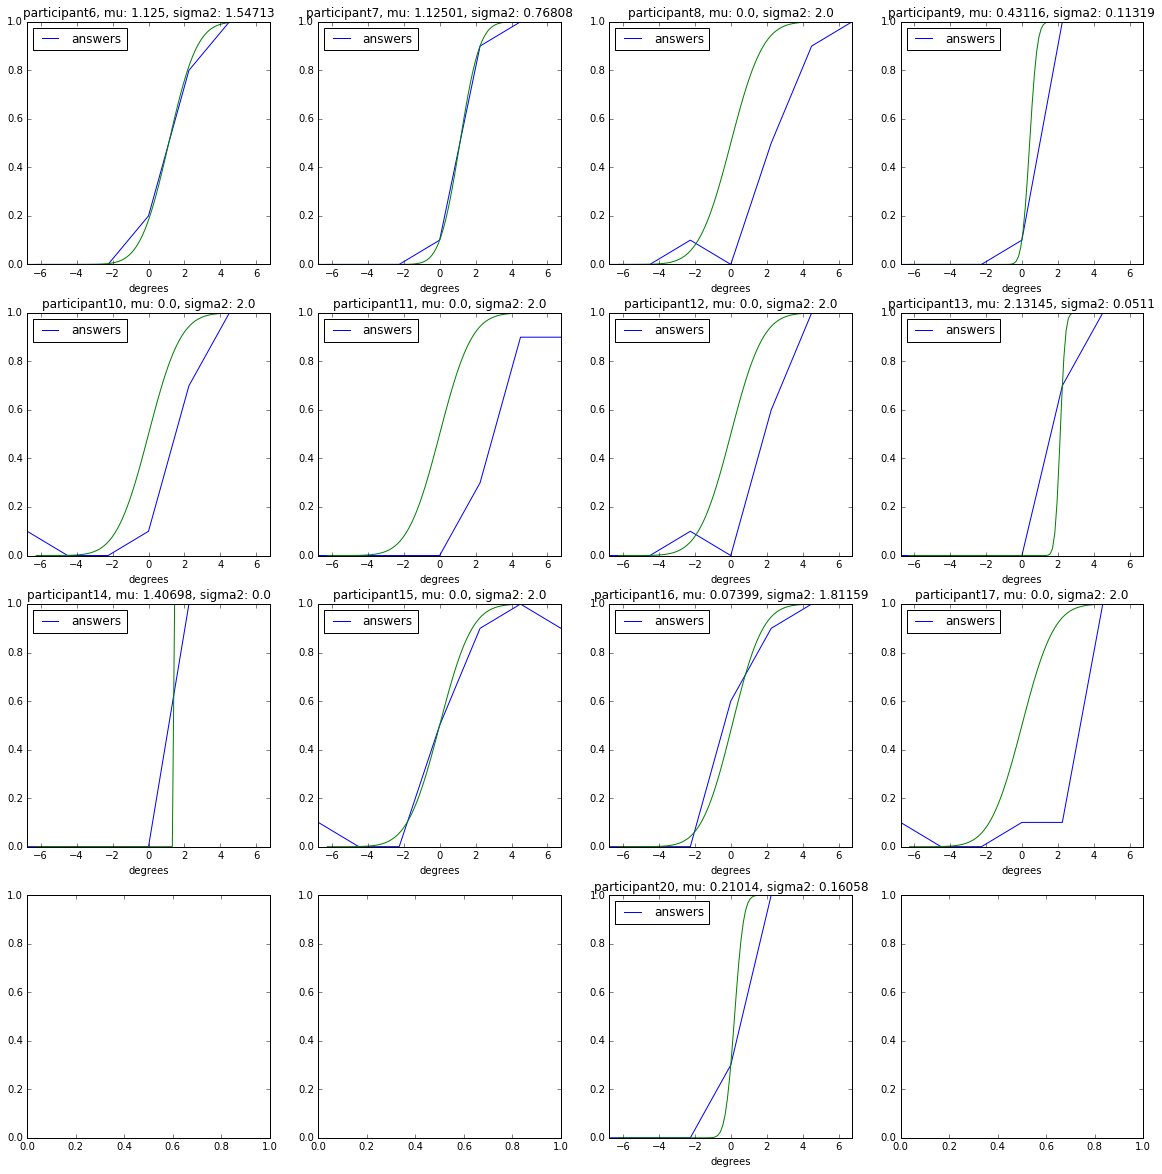

In [46]:
#graph the data points and the fitted distributions
fig = plt.figure(figsize = (20, 20))
for i in range(5, 21):
    # stange indexing here - should be (i-5)+1 but rewrite it nicer!
    ax = fig.add_subplot(4,4,i-4)
    for result in all_participants_audio:
        if result['participant'] == 'participant' + str(i+1):
            name = 'participant' + str(i+1)
            # plot the real datapoints
            data = result['data']
            data_frame = pd.DataFrame(data).T
            data_frame.columns = ['degrees', 'answers']
            points = data_frame.groupby('degrees').mean()
            points.plot(ax = ax)
            # plot the fitted cumulative normal distribution
            mu = result['mu']
            sigma2 = result['sigma2']
            ax.title.set_text(str(name) + ', mu: ' + str(round(mu, 5)) + ', sigma2: ' + str(round(sigma2, 5)))
            x = np.linspace(-6.25, 6.25, 100)
            ax.plot(x,phi(x, mu, sigma2))
plt.show()  

### - aggregated over all audio results

In [47]:
import itertools

In [48]:
# TODO: aggregate over all audio results and check then 
audio_aggegrated = []
for filename in os.listdir('data/preprocessed/audio'):
    if filename.endswith('.p'):
        number = int(filename[11:-2])
        if number > 4:
            audio_aggegrated.append(pickle.load( open('data/preprocessed/audio/' + filename, "rb" )))


In [49]:
locations = [] 
answers = []
for item in audio_aggegrated:
    locations.append(item[0])
    answers.append(item[1,:])

In [50]:
locations = list(itertools.chain(*locations))
answers = list(itertools.chain(*answers))

In [ ]:
aggregated_data = np.array([locations, answers])
results = compute_MLE_1(aggregated_data, global_opt=True)

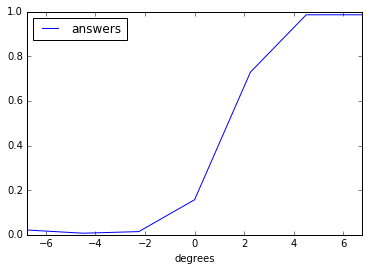

In [58]:
data_frame = pd.DataFrame(aggregated_data).T
data_frame.columns = ['degrees', 'answers']
points = data_frame.groupby('degrees').mean()
points.plot()

## play around with likelihood function

In [78]:
sigma2 = np.arange(0, 10, 0.2)
sigma2
results = [round1_likelihood(locations, answers, 1.8, x) for x in sigma2]
#plt.plot(sigma2, lambda x: round1_likelihood(locations, answers, 1.125, x))

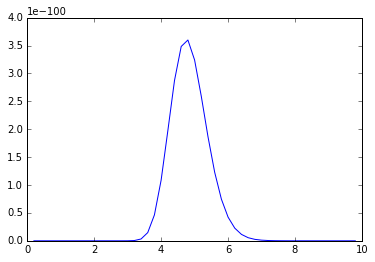

In [79]:
plt.plot(sigma2, results)

### - video

In [280]:
all_participants_video = []
for filename in os.listdir('data/preprocessed/video'):
    if filename.endswith('.p'):
        print(filename)
        number = filename[11:-2]
        data = pickle.load( open('data/preprocessed/video/' + filename, "rb" ) )
         #only consider the ones after the 4th where we didn't mess up (: 
        if int(number) > 4:
            for noise in data.keys():
                data_here = data[noise]
                results = compute_MLE_1(data_here)
                results['noise'] = noise
                results['data'] = data
                results['participant'] = filename[:-2]
                all_participants_video.append(results)

participant1.p
     fun: 0.99999992213101851
     jac: array([  4.44089210e-08,  -2.22044605e-08])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 83
     nit: 6
  status: 1
 success: True
       x: array([ 0.14618589,  3.65086071])
     fun: 0.99998277176729777
     jac: array([  0.00000000e+00,   1.11022302e-08])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 51
     nit: 5
  status: 1
 success: True
       x: array([ 1.24666692,  2.17807988])
     fun: 1.0
     jac: array([ 0.,  0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 1
     nit: 0
  status: 0
 success: True
       x: array([ 0.,  2.])
     fun: 1.0
     jac: array([ 0.,  0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 1
     nit: 0
  status: 0
 success: True
       x: array([ 0.,  2.])
     fun: 0.99999999999979727
     jac: array([ 0.,  0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 1
     nit: 0
  status: 0
 success: True
       x: array([ 0.,  2.])
participant10.p
     f

In [295]:
#cutting of first 5 in a slightly weird way
video_results = pd.DataFrame([result for result in all_participants_video if int(result['participant'][11:]) >4] )
video_results

,data,mu,noise,participant,sigma2
0,"{0.1: [[4.5, -4.5, 2.25, -6.75, -2.25, 6.75, 0...",0.496912,0.10,participant10,4.121517
1,"{0.1: [[4.5, -4.5, 2.25, -6.75, -2.25, 6.75, 0...",-0.126763,0.23,participant10,1.856434
2,"{0.1: [[4.5, -4.5, 2.25, -6.75, -2.25, 6.75, 0...",0.000000,0.62,participant10,2.000000
3,"{0.1: [[4.5, -4.5, 2.25, -6.75, -2.25, 6.75, 0...",0.000000,0.49,participant10,2.000000
4,"{0.1: [[4.5, -4.5, 2.25, -6.75, -2.25, 6.75, 0...",-0.828655,0.36,participant10,2.508211
5,"{0.1: [[4.5, 6.75, -2.25, 2.25, 0.0, -4.5, -6....",0.000000,0.10,participant11,2.000000
6,"{0.1: [[4.5, 6.75, -2.25, 2.25, 0.0, -4.5, -6....",0.000000,0.23,participant11,2.000000
7,"{0.1: [[4.5, 6.75, -2.25, 2.25, 0.0, -4.5, -6....",0.000000,0.62,participant11,2.000000
8,"{0.1: [[4.5, 6.75, -2.25, 2.25, 0.0, -4.5, -6....",0.000000,0.49,participant11,2.000000
9,"{0.1: [[4.5, 6.75, -2.25, 2.25, 0.0, -4.5, -6....",0.000000,0.36,participant11,2.000000


In [288]:
final_video_results = video_results.groupby(['participant','noise']).mean()
final_video_results[final_video_results['mu']>0]
#video_results.groupby('noise').mean()
#final_video_results

mu    sigma2
participant   noise                    
participant10 0.10   0.496912  4.121517
participant12 0.36   0.933437  4.063852
              0.49   0.427505  0.111278
              0.62   0.833755  2.018170
participant13 0.10   0.301795  0.128583
              0.23   0.449980  0.123286
              0.36   0.452565  0.124707
              0.49   0.209988  0.160314
participant14 0.23   0.301795  0.128583
              0.49   0.896412  1.084253
participant15 0.10   0.088794  0.122855
              0.23   0.087841  0.120222
participant17 0.10   0.301795  0.128583
              0.36   0.301795  0.128583
              0.49   0.209963  0.160310
participant20 0.23   0.088794  0.122855
              0.36   0.209988  0.160314
              0.49   0.209988  0.160314
              0.62   0.126915  1.856522
participant5  0.10   0.668184  2.495060
              0.23   1.921051  0.065885
              0.36   1.003120  2.171281
              0.49   0.087841  0.120222
participant6  0.10   1.406975  0.000010
              0.23   1.406975  0.000010
              0.36   0.209988  0.160314
              0.49   1.246667  2.178080
participant7  0.10   1.246667  2.178080
              0.23   0.267085  3.631250
participant8  0.10   1.406975  0.000010
              0.23   1.406975  0.000010
              0.36   0.454384  0.125654
              0.49   1.246667  2.178080
              0.62   0.301795  0.128583
participant9  0.10   1.406975  0.000010
              0.23   1.406975  0.000010
              0.36   1.406975  0.000010
              0.62   0.301795  0.128583

In [294]:
for row in final_video_results.iterrows():
    number = int(row[0][0][11:])
    print(number, row[1])

16 mu       -0.530556
sigma2    1.780275
Name: (Participant16, 0.1), dtype: float64
16 mu        0.0
sigma2    2.0
Name: (Participant16, 0.23), dtype: float64
16 mu        0.0
sigma2    2.0
Name: (Participant16, 0.36), dtype: float64
16 mu       -0.522890
sigma2    4.479637
Name: (Participant16, 0.49), dtype: float64
16 mu        0.0
sigma2    2.0
Name: (Participant16, 0.62), dtype: float64
10 mu        0.496912
sigma2    4.121517
Name: (participant10, 0.1), dtype: float64
10 mu       -0.126763
sigma2    1.856434
Name: (participant10, 0.23), dtype: float64
10 mu       -0.828655
sigma2    2.508211
Name: (participant10, 0.36), dtype: float64
10 mu        0.0
sigma2    2.0
Name: (participant10, 0.49), dtype: float64
10 mu        0.0
sigma2    2.0
Name: (participant10, 0.62), dtype: float64
11 mu        0.0
sigma2    2.0
Name: (participant11, 0.1), dtype: float64
11 mu        0.0
sigma2    2.0
Name: (participant11, 0.23), dtype: float64
11 mu        0.0
sigma2    2.0
Name: (participant11, 

In [ ]:
#graph the data points and the fitted distributions
fig = plt.figure(figsize = (20, 20))
for i in range(5, 21):
    # stange indexing here - should be (i-5)+1 but rewrite it nicer!
    ax = fig.add_subplot(4,4,i-4)
    for result in all_participants_video:
        if result['participant'] == 'participant' + str(i+1):
            name = 'participant' + str(i+1)
            # plot the real datapoints
            data = result['data']
            data_frame = pd.DataFrame(data).T
            data_frame.columns = ['degrees', 'answers']
            points = data_frame.groupby('degrees').mean()
            points.plot(ax = ax)
            # plot the fitted cumulative normal distribution
            mu = result['mu']
            sigma2 = result['sigma2']
            ax.title.set_text(str(name) + ', mu: ' + str(round(mu, 5)) + ', sigma2: ' + str(round(sigma2, 5)))
            x = np.linspace(-6.25, 6.25, 100)
            ax.plot(x,phi(x, mu, sigma2))
plt.show()  

In [296]:
final_video_results['visual_weights'] = wfv_vectorized(final_video_results['sigma2'].as_matrix(), np.repeat(audio_results['sigma2'].as_matrix(), 5))
final_video_results

mu    sigma2  visual_weights
participant   noise                                    
Participant16 0.10  -0.530556  1.780275        0.529062
              0.23   0.000000  2.000000        0.500000
              0.36   0.000000  2.000000        0.500000
              0.49  -0.522890  4.479637        0.308659
              0.62   0.000000  2.000000        0.500000
participant10 0.10   0.496912  4.121517        0.326716
              0.23  -0.126763  1.856434        0.518614
              0.36  -0.828655  2.508211        0.443635
              0.49   0.000000  2.000000        0.500000
              0.62   0.000000  2.000000        0.500000
participant11 0.10   0.000000  2.000000        0.500000
              0.23   0.000000  2.000000        0.500000
              0.36   0.000000  2.000000        0.500000
              0.49   0.000000  2.000000        0.500000
              0.62   0.000000  2.000000        0.500000
participant12 0.10   0.000000  2.000000        0.024919
              0.23   0.000000  2.000000        0.024919
              0.36   0.933437  4.063852        0.012421
              0.49   0.427505  0.111278        0.314749
              0.62   0.833755  2.018170        0.024701
participant13 0.10   0.301795  0.128583        0.000078
              0.23   0.449980  0.123286        0.000081
              0.36   0.452565  0.124707        0.000080
              0.49   0.209988  0.160314        0.000062
              0.62   0.000000  2.000000        0.000005
participant14 0.10   0.000000  2.000000        0.500000
              0.23   0.301795  0.128583        0.939592
              0.36   0.000000  2.000000        0.500000
              0.49   0.896412  1.084253        0.648455
              0.62   0.000000  2.000000        0.500000
...                       ...       ...             ...
participant20 0.10   0.000000  2.000000        0.074207
              0.23   0.088794  0.122855        0.566137
              0.36   0.209988  0.160314        0.499994
              0.49   0.209988  0.160314        0.499994
              0.62   0.126915  1.856522        0.079486
participant5  0.10   0.668184  2.495060        0.444933
              0.23   1.921051  0.065885        0.968108
              0.36   1.003120  2.171281        0.479469
              0.49   0.087841  0.120222        0.943297
              0.62   0.000000  2.000000        0.500000
participant6  0.10   1.406975  0.000010        0.999994
              0.23   1.406975  0.000010        0.999994
              0.36   0.209988  0.160314        0.906109
              0.49   1.246667  2.178080        0.415314
              0.62   0.000000  2.000000        0.436164
participant7  0.10   1.246667  2.178080        0.260705
              0.23   0.267085  3.631250        0.174590
              0.36   0.000000  2.000000        0.277477
              0.49   0.000000  2.000000        0.277477
              0.62   0.000000  2.000000        0.277477
participant8  0.10   1.406975  0.000010        0.999995
              0.23   1.406975  0.000010        0.999995
              0.36   0.454384  0.125654        0.940887
              0.49   1.246667  2.178080        0.478689
              0.62   0.301795  0.128583        0.939592
participant9  0.10   1.406975  0.000010        0.999912
              0.23   1.406975  0.000010        0.999912
              0.36   1.406975  0.000010        0.999912
              0.49   0.000000  2.000000        0.053834
              0.62   0.301795  0.128583        0.469493

[70 rows x 3 columns]

## Second round of experiments:
Compare the weights obtained in the second experiment (and thus the model for multisensory integration) and compare it with empirical results. The empirical weights are again found via a maximum likelihood estimation similar to the monosensory trials, but with a modified probability $p_t$:
\begin{align}
\widehat{w}_a, \widehat{w}_v &= argmax_{w_a, w_v} \prod_{t=1}^{T} p_t^{r_t} (1-p_t)^{1-r_t} \\
&= argmax_{w_a, w_v} \prod_{t=1}^{T} (\frac{1}{1 + exp[-(L_c - L_s)/\tau]})^{r_t} (1-(\frac{1}{1 + exp[-(L_c - L_s)/\tau])}^{1-r_t}) \\
&= argmax_{w_a, w_v} \prod_{t=1}^{T} (\frac{1}{1 + exp[-(w_vL_v^c + w_aL_a^c - (w_vL_v^s + w_aL_a^s))/\tau]})^{r_t} (1-(\frac{1}{1 + exp[-(w_vL_v^c + w_aL_a^c - (w_vL_v^s + w_aL_a^s)))/\tau])}^{1-r_t})
\end{align}

*NOTE: I am still ab bit confused about their explanation with 'location estimates' here. I think we probably just have to use the actual locations because we don't really have any location estimates other than the mean of the two distributions fitted in the first round which should just be very close to zero. Is this just a mistake in the paper?
Related question: the visual and audio location is the same in the comparison stimulus then, right? Then L_c collapses  (since the weights sum to 1) Also it makes no sense to optimize for both of the weights since they are constrained to sum to one.*
With these assumptions the equation would simplify to 

$$
argmax_{w_a, w_v} \prod_{t=1}^{T} (\frac{1}{1 + exp[-(L_c - (w_vL_v^s + (1-w_v)L_a^s))/\tau]})^{r_t} (1-(\frac{1}{1 + exp[-(L_c - (w_vL_v^s + (1-w_v)L_a^s)))/\tau])}^{1-r_t}).
$$

In [227]:
# rewrite w_a = 1 - w_v
def round2_likelihood(degrees, answers, w_v, tau):
    l_s_a = 2.25
    l_s_v = -2.25
    # adjusted paper locations to our 7-location setting - is this CORRECT?
    likelihood = 1
    # model the product
    for t in range(len(degrees)):
        #likelihood = (likelihood * 1 / (1 + exp(- (L[t] - w_v*l_s_v + w_a*l_s_a))/tau)**answers[t] 
        #                        * ( 1 - 1 / (1 + exp(- (L[t] - w_v*l_s_v + w_a*l_s_a))/tau))**(1 - answers[t]))
        # rewrite w_a = 1 - w_v
        likelihood = likelihood * (1 / (1 + exp(- (degrees[t] - (w_v*l_s_v + (1-w_v)*l_s_a))/tau))**answers[t] 
                                * ( 1 - (1 / (1 + exp(- (degrees[t] - w_v*l_s_v + (1-w_v)*l_s_a))/tau)))**(1 - answers[t]))
    return likelihood

In [279]:
def compute_MLE_2(data):
    degrees = data[0, :]
    print(degrees)
    answers = data[1, :]
    print(answers)
    result = optimize.minimize(lambda x: 1-round2_likelihood(degrees, answers, *x), 
                               [0.200000, 1.000000], method = 'L-BFGS-B' , bounds = [(0, 1),(None, None)], tol =1e-10)['x']
    w_a = result[0]
    tau = result[1]
    return {'w_a':w_a, 'tau':tau}

### Apply to our data - combined

In [280]:
all_participants_combined = []
for filename in os.listdir('data/preprocessed/combined'):
    if filename.endswith('.p'):
        print(filename)
        data = pickle.load( open('data/preprocessed/combined/' + filename, "rb" ) )
        for noise in data.keys():
            data_here = data[noise]
            print(data_here.shape)
            results = compute_MLE_2(data_here)
            results['noise'] = noise
            results['participant'] = filename[:-2]
            all_participants_combined.append(results)

participant1.p
(2, 70)
[-2.25 -6.75  6.75  6.75 -2.25  4.5   4.5  -4.5   0.   -6.75  6.75  2.25
  4.5   6.75  4.5   0.   -6.75  0.    6.75  2.25  4.5   6.75 -4.5   0.
 -2.25  4.5   0.   -6.75 -4.5   0.   -4.5   6.75  2.25  2.25  0.    2.25
 -4.5  -4.5  -2.25 -6.75  6.75 -6.75 -6.75  2.25  6.75  2.25  2.25 -2.25
 -6.75  0.    2.25 -2.25  4.5  -4.5   0.   -4.5  -2.25 -4.5  -6.75  6.75
 -2.25 -6.75  4.5  -2.25  4.5   0.    2.25  4.5  -4.5  -2.25]
[ 0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.
  1.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.]
(2, 70)
[-4.5   6.75 -6.75  2.25 -4.5   0.   -6.75  6.75 -2.25 -2.25  6.75  2.25
  6.75  4.5   0.    2.25  0.    2.25 -6.75  0.   -6.75 -6.75  2.25 -2.25
  6.75  2.25  2.25  4.5   4.5  -2.25  4.5   4.5  -4.5  -2.25 -2.25 -4.5   0.
 -6.75 -2.25 -4.5  -2.25  6.75  0.  

In [281]:
all_participants_combined

[{'noise': 0.1,
  'participant': 'participant1',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.23,
  'participant': 'participant1',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.62,
  'participant': 'participant1',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.49,
  'participant': 'participant1',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.36,
  'participant': 'participant1',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.1,
  'participant': 'participant10',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.23,
  'participant': 'participant10',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.62,
  'participant': 'participant10',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.49,
  'participant': 'participant10',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.36,
  'participant': 'participant10',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.1,
  'participant': 'participant2'